# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from tqdm import tqdm
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [ ]:
negative =[]
positive = []
neutral = []
comp = []

def sentiment_update(values):
  negative.append(values["neg"])
  positive.append(values["pos"])
  neutral.append(values["neu"])
  comp.append(values["compound"])

  

In [ ]:
#from tqdm import tqdm 
for essay in tqdm(data["essay"]):
  sentiment_update(sid.polarity_scores(essay))
  

100%|██████████| 109248/109248 [03:50<00:00, 474.10it/s]


In [ ]:
#new features adding to the dataset on sentiment intensity analyser
data["neg"] = negative
data["pos"] = positive
data["neu"] = neutral
data["compound"] = comp

In [ ]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,pos,neu,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.248,0.680,0.9897


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
y = data["project_is_approved"].values
x = data.drop(["project_is_approved"],axis=1)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,stratify=y,random_state=42)
print(len(y_train))
print(len(y_test))

73196
36052


Encoding the Essay feature

In [ ]:
tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=5000)
#fitting the text
tfidf_text  = tfidfvectorizer.fit(x_train['essay'].values)

#transforming the text
x_tr_ess_tfidf = tfidfvectorizer.transform(x_train['essay'].values)
x_te_ess_tfidf = tfidfvectorizer.transform(x_test['essay'].values)

print(x_tr_ess_tfidf,y_train.shape)
print(x_te_ess_tfidf,y_test.shape)


  (0, 4988)	0.07845321848421512
  (0, 4951)	0.05541923129681841
  (0, 4919)	0.08502843356840221
  (0, 4864)	0.12854994173323547
  (0, 4848)	0.1621148422760008
  (0, 4829)	0.048936165181412215
  (0, 4742)	0.06329875330786552
  (0, 4592)	0.09446835673076666
  (0, 4576)	0.06129627229238638
  (0, 4563)	0.04832672937276115
  (0, 4535)	0.04415155487010553
  (0, 4532)	0.13222274067406695
  (0, 4523)	0.035470139454669224
  (0, 4505)	0.034689615010315394
  (0, 4472)	0.11035722075299437
  (0, 4364)	0.06645624580034992
  (0, 4339)	0.14278631460752597
  (0, 4338)	0.04844274923441687
  (0, 4258)	0.09267828379428465
  (0, 4146)	0.10931501299374669
  (0, 4109)	0.14742191205699548
  (0, 4017)	0.09104238447425712
  (0, 3983)	0.08691818064850412
  (0, 3932)	0.10970153354926372
  (0, 3866)	0.073932100743522
  :	:
  (73195, 1638)	0.1254552067637354
  (73195, 1635)	0.058573956633454084
  (73195, 1619)	0.08103373845908134
  (73195, 1336)	0.11353544491526235
  (73195, 1288)	0.1130439573533104
  (73195, 1273)

In [ ]:
import pickle
with open('glove_vectors','rb') as f:
  model = pickle.load(f)
  glove_words = set(model.keys())
  

In [ ]:
model_tfidf = TfidfVectorizer()
model_tfidf.fit(x_train["essay"].values)
dictionary = dict(zip(model_tfidf.get_feature_names(),list(model_tfidf.idf_)))
words_tfidf = set(model_tfidf.get_feature_names())


In [ ]:
tr_tfidf_w2v_ess = []
for sent in tqdm(x_train["essay"]):
  vect = np.zeros(300)
  tfidf_weight = 0
  for wrd in sent.split():
    if(wrd in glove_words) and (wrd in words_tfidf):
      vec = model[wrd]
      tf_idf = dictionary[wrd]*(sent.count(wrd)/len(sent.split()))
      vect = vect + (vec * tf_idf)
      tfidf_weight = tfidf_weight + tf_idf
  if tfidf_weight != 0:
    vect = vect/tfidf_weight
  tr_tfidf_w2v_ess.append(vect)
x_tr_ess_tdidf_w2v = sparse.csr_matrix(tr_tfidf_w2v_ess)
print(x_tr_ess_tdidf_w2v.shape,y_train.shape)



100%|██████████| 73196/73196 [02:28<00:00, 493.61it/s]


(73196, 300) (73196,)


In [ ]:
te_tfidf_w2v_ess = []
for sent in tqdm(x_test["essay"]):
  vect = np.zeros(300)
  tfidf_weight = 0
  for wrd in sent.split():
    if(wrd in glove_words) and (wrd in words_tfidf):
      vec = model[wrd]
      tf_idf = dictionary[wrd]*(sent.count(wrd)/len(sent.split()))
      vect = vect + (vec * tf_idf)
      tfidf_weight = tfidf_weight + tf_idf
  if tfidf_weight != 0:
    vect = vect/tfidf_weight
  te_tfidf_w2v_ess.append(vect)
x_te_ess_tdidf_w2v = sparse.csr_matrix(te_tfidf_w2v_ess)
print(x_te_ess_tdidf_w2v.shape,y_test.shape)

100%|██████████| 36052/36052 [01:12<00:00, 496.40it/s]


(36052, 300) (36052,)


Encoding Categorical Features

In [ ]:
def fitting(feature):
  x_train["class_label"] = y_train
  cnt = x_train[feature].value_counts()
  feature_dict = dict()
  for i,denominator in cnt.items():
    vect = []
    for j in range(2):
      comp = x_train.loc[(x_train["class_label"]==j)&(x_train[feature]==i)]
      vect.append(len(comp)/denominator)
    feature_dict[i] = vect
  return feature_dict
def transform(feature,df):
  feature_dict = fitting(feature)
  cnt = x_train[feature].value_counts()
  f=[]
  for cat in df[feature]:
    if cat in dict(cnt).keys():
      f.append(feature_dict[cat])
    else:
      f.append([0.5,0.05])
  return f

Encoding School State

In [ ]:
x_tr_school = np.array(transform('school_state',x_train))
x_te_school = np.array(transform('school_state',x_test))

print(x_tr_school.shape,y_train.shape)
print(x_te_school.shape,y_test.shape)


(73196, 2) (73196,)
(36052, 2) (36052,)


Encodinng teacher prefix

In [ ]:
x_tr_prefix = np.array(transform('teacher_prefix',x_train))
x_te_prefix = np.array(transform('teacher_prefix',x_test))

print(x_tr_prefix.shape,y_train.shape)
print(x_te_prefix.shape,y_test.shape)

(73196, 2) (73196,)
(36052, 2) (36052,)


Encoding Project grade category

In [ ]:
x_tr_grade = np.array(transform('project_grade_category',x_train))
x_te_grade = np.array(transform('project_grade_category',x_test))

print(x_tr_grade.shape,y_train.shape)
print(x_te_grade.shape,y_test.shape)

(73196, 2) (73196,)
(36052, 2) (36052,)


Encoding Clean Categories

In [ ]:
x_tr_cat = np.array(transform('clean_categories',x_train))
x_te_cat = np.array(transform('clean_categories',x_test))

print(x_tr_cat.shape,y_train.shape)
print(x_te_cat.shape,y_test.shape)

(73196, 2) (73196,)
(36052, 2) (36052,)


Encoding Clean subcategories

In [ ]:
x_tr_subcat = np.array(transform('clean_subcategories',x_train))
x_te_subcat = np.array(transform('clean_subcategories',x_test))

print(x_tr_subcat.shape,y_train.shape)
print(x_te_subcat.shape,y_test.shape)

(73196, 2) (73196,)
(36052, 2) (36052,)


In [ ]:
print(len(x_train['price']))
x_train['price'].values.reshape(1,-1)

73196


array([[742.2 , 412.92, 647.91, ..., 282.15,  90.94, 235.46]])

Encoding the numerical feature of price

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_tr_price_norm = normalizer.transform(x_train['price'].values.reshape(1,-1)).reshape(-1,1)
x_te_price_norm = normalizer.transform(x_test['price'].values.reshape(1,-1)).reshape(-1,1)

print(x_tr_price_norm.shape,y_train.shape)
print(x_te_price_norm.shape,y_test.shape)



(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding teacher number of previously posted projects

In [ ]:
print(len(x_train['teacher_number_of_previously_posted_projects']))
x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)

73196


array([[13,  4,  0, ...,  1,  1,  0]])

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

x_tr_prev_proj = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
x_te_prev_proj = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)

print(x_tr_prev_proj.shape,y_train.shape)
print(x_te_prev_proj.shape,y_test.shape)


(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding for negative

In [ ]:
print(len(x_train['neg']))
x_train['neg'].values.reshape(1,-1)

73196


array([[0.045, 0.034, 0.047, ..., 0.036, 0.039, 0.081]])

In [ ]:
normalizer = Normalizer()

x_tr_neg = normalizer.transform(x_train['neg'].values.reshape(1,-1)).reshape(-1,1)
x_te_neg = normalizer.transform(x_test['neg'].values.reshape(1,-1)).reshape(-1,1)

print(x_tr_neg.shape,y_train.shape)
print(x_te_neg.shape,y_test.shape)


(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding for positive

In [ ]:
print(len(x_train['pos']))
x_train['pos'].values.reshape(1,-1)

73196


array([[0.255, 0.267, 0.331, ..., 0.277, 0.307, 0.193]])

In [ ]:
normalizer = Normalizer()

x_tr_pos = normalizer.transform(x_train['pos'].values.reshape(1,-1)).reshape(-1,1)
x_te_pos = normalizer.transform(x_test['pos'].values.reshape(1,-1)).reshape(-1,1)

print(x_tr_pos.shape,y_train.shape)
print(x_te_pos.shape,y_test.shape)


(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding for neutral

In [ ]:
print(len(x_train['neu']))
x_train['neu'].values.reshape(1,-1)

73196


array([[0.7  , 0.699, 0.622, ..., 0.686, 0.654, 0.726]])

In [ ]:
normalizer = Normalizer()

x_tr_neu = normalizer.transform(x_train['neu'].values.reshape(1,-1)).reshape(-1,1)
x_te_neu = normalizer.transform(x_test['neu'].values.reshape(1,-1)).reshape(-1,1)

print(x_tr_neu.shape,y_train.shape)
print(x_te_neu.shape,y_test.shape)

(73196, 1) (73196,)
(36052, 1) (36052,)


Encoding for compound

In [ ]:
print(len(x_train['compound']))
x_train['compound'].values.reshape(1,-1)

73196


array([[0.9831, 0.9822, 0.9925, ..., 0.9934, 0.9879, 0.9588]])

In [ ]:
normalizer = Normalizer()

x_tr_comp = normalizer.transform(x_train['compound'].values.reshape(1,-1)).reshape(-1,1)
x_te_comp = normalizer.transform(x_test['compound'].values.reshape(1,-1)).reshape(-1,1)

print(x_tr_comp.shape,y_train.shape)
print(x_te_comp.shape,y_test.shape)

(73196, 1) (73196,)
(36052, 1) (36052,)


Combining all the features 

SET 1

In [ ]:
from scipy.sparse import hstack
x_tr1 = hstack((x_tr_ess_tfidf,x_tr_school,x_tr_prefix,x_tr_grade,x_tr_cat,x_tr_subcat,x_tr_price_norm,x_tr_prev_proj,x_tr_neg,x_tr_pos,x_tr_neu,x_tr_comp)).tocsr()
x_te1 = hstack((x_te_ess_tfidf,x_te_school,x_te_prefix,x_te_grade,x_te_cat,x_te_subcat,x_te_price_norm,x_te_prev_proj,x_te_neg,x_te_pos,x_te_neu,x_te_comp)).tocsr()


In [ ]:
print(x_tr1.shape)
print(x_te1.shape)

(73196, 5016)
(36052, 5016)


SET 2

In [ ]:
from scipy.sparse import hstack
x_tr2 = hstack((x_tr_ess_tdidf_w2v,x_tr_school,x_tr_prefix,x_tr_grade,x_tr_cat,x_tr_subcat,x_tr_price_norm,x_tr_prev_proj,x_tr_neg,x_tr_pos,x_tr_neu,x_tr_comp)).tocsr()
x_te2 = hstack((x_te_ess_tdidf_w2v,x_te_school,x_te_prefix,x_te_grade,x_te_cat,x_te_subcat,x_te_price_norm,x_te_prev_proj,x_te_neg,x_te_pos,x_te_neu,x_te_comp)).tocsr()


In [ ]:
print(x_tr2.shape)
print(x_te2.shape)

(73196, 316)
(36052, 316)


Gradient boost classifier with grid search cross validation on SET1 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

params = {"max_depth":[1,2,3,4], "n_estimators":[5,10,15,20]}
clf = GridSearchCV(GradientBoostingClassifier(),params,cv=5,scoring="roc_auc",return_train_score=True,n_jobs=-1)
clf.fit(x_tr1,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [ ]:
tr_auc = clf.cv_results_['mean_test_score']
tr_std_auc = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_std_auc = clf.cv_results_['std_test_score']

In [ ]:
print("best score is ", clf.best_score_)
print("best hyper parameter is", clf.best_params_)

best score is  0.6849131393113354
best hyper parameter is {'max_depth': 4, 'n_estimators': 20}


plot for hypermater and auc

Roc plots for train and test data

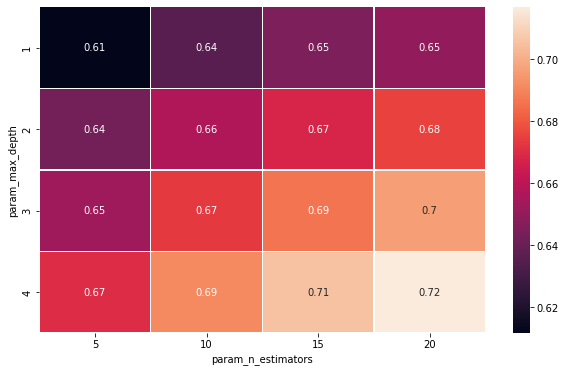

In [ ]:
import pandas as pd #for test data
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),values = 'mean_train_score', index = 'param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(10,6))
xa = sns.heatmap(pvt,annot=True,linewidth=0.5)

Roc plot fot train and test data

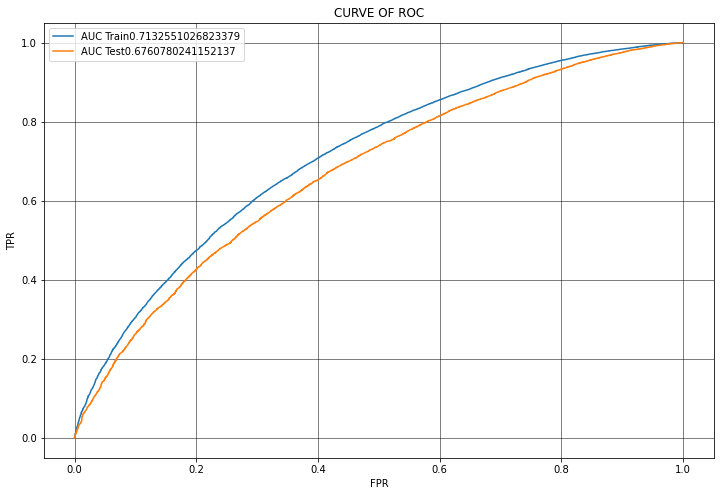

In [ ]:
set1_model  = GradientBoostingClassifier(max_depth = clf.best_params_['max_depth'],n_estimators=clf.best_params_['n_estimators'])
set1_model.fit(x_tr1,y_train)
y_tr_probs = clf.predict_proba(x_tr1)[:,1]
y_te_probs = clf.predict_proba(x_te1)[:,1]

tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train,y_tr_probs)
te_fpr, te_tpr, te_thresholds = roc_curve(y_test,y_te_probs)

plt.figure(figsize=(12,8))
plt.plot(tr_fpr, tr_tpr, label="AUC Train"+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="AUC Test" +str(auc(te_fpr, te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("CURVE OF ROC")
plt.grid(color='black',lw=0.5)


Confusion Matrixx

In [ ]:
def find_best_threshold(threshold,fpr,tpr):
  thresh = threshold[np.argmax(tpr*(1-fpr))]
  #best threshold to know the class labels
  print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(thresh,3))
  return thresh

def predict_with_best_t(proba,threshold):
  predicts = []
  for i in proba:
    if i>=threshold:
      predicts.append(1)
    else:
      predicts.append(0)
  return predicts

the maximum value of tpr*(1-fpr) 0.4297759568082888 for threshold 0.849
[[ 7329  3754]
 [21745 40368]]


Text(0.5, 1.0, 'confusion matrix for Train Data')

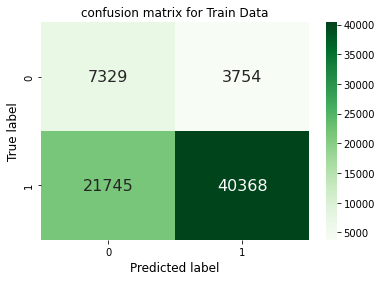

In [ ]:
t_best = find_best_threshold(tr_thresholds,tr_fpr, tr_tpr)
cm = metrics.confusion_matrix(y_train,predict_with_best_t(y_tr_probs,t_best))

print(cm)
sns.heatmap(cm,annot=True,fmt='d',cmap='Greens',annot_kws={'size':16})
plt.xlabel('Predicted label', size=12)
plt.ylabel('True label', size=12)
plt.title('confusion matrix for Train Data',size=12)


the maximum value of tpr*(1-fpr) 0.3942256688629814 for threshold 0.844
[[ 3355  2104]
 [10969 19624]]


Text(0.5, 1.0, 'confusion matrix for Train Data')

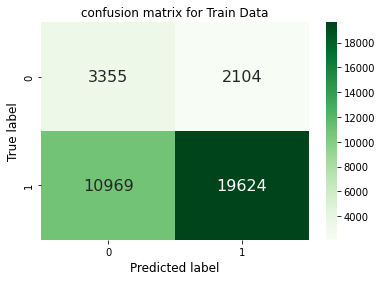

In [ ]:
t_best = find_best_threshold(te_thresholds,te_fpr, te_tpr)
cm = metrics.confusion_matrix(y_test,predict_with_best_t(y_te_probs,t_best))

print(cm)
sns.heatmap(cm,annot=True,fmt='d',cmap='Greens',annot_kws={'size':16})
plt.xlabel('Predicted label', size=12)
plt.ylabel('True label', size=12)
plt.title('confusion matrix for Train Data',size=12)


Gradient boost classifier with grid search cross validation on SET2

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

params = {"max_depth":[1,2,3,4], "n_estimators":[5,10,15,20]}
clf = GridSearchCV(GradientBoostingClassifier(),params,cv=5,scoring="roc_auc",return_train_score=True,n_jobs=-1)
clf.fit(x_tr2,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [59]:
tr_auc = clf.cv_results_['mean_test_score']
tr_std_auc = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_std_auc = clf.cv_results_['std_test_score']

In [60]:
print("best score is ", clf.best_score_)
print("best hyper parameter is", clf.best_params_)

best score is  0.6905534615895192
best hyper parameter is {'max_depth': 4, 'n_estimators': 20}


plot for hypermater and auc

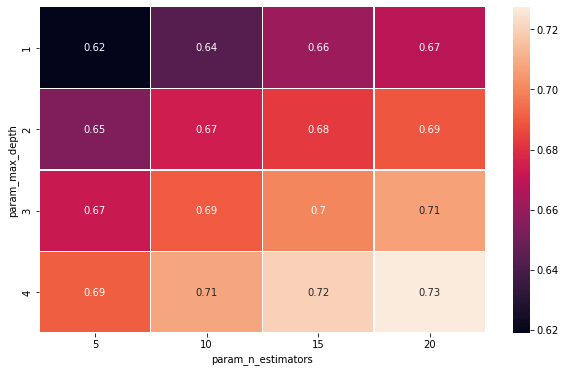

In [61]:
import pandas as pd #for test data
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),values = 'mean_train_score', index = 'param_max_depth', columns='param_n_estimators')
plt.figure(figsize=(10,6))
xa = sns.heatmap(pvt,annot=True,linewidth=0.5)

Roc plot fot train and test data

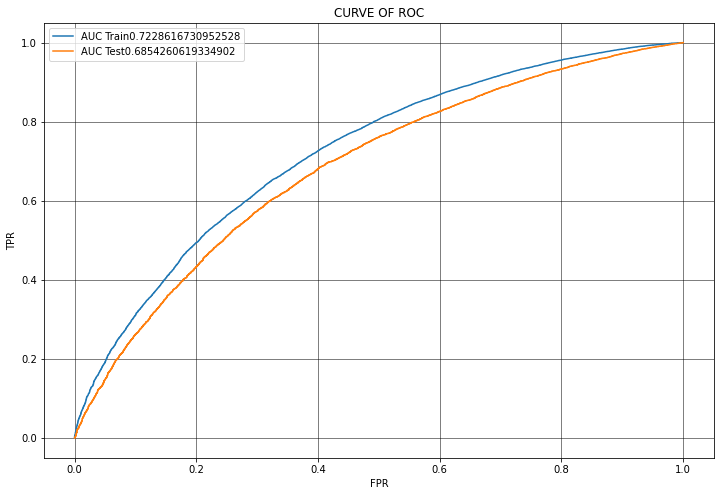

In [62]:
set2_model  = GradientBoostingClassifier(max_depth = clf.best_params_['max_depth'],n_estimators=clf.best_params_['n_estimators'])
set2_model.fit(x_tr2,y_train)
y_tr_probs = clf.predict_proba(x_tr2)[:,1]
y_te_probs = clf.predict_proba(x_te2)[:,1]

tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_train,y_tr_probs)
te_fpr, te_tpr, te_thresholds = roc_curve(y_test,y_te_probs)

plt.figure(figsize=(12,8))
plt.plot(tr_fpr, tr_tpr, label="AUC Train"+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr, te_tpr, label="AUC Test" +str(auc(te_fpr, te_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("CURVE OF ROC")
plt.grid(color='black',lw=0.5)

Confusion Matrix

In [63]:
def find_best_threshold(threshold,fpr,tpr):
  thresh = threshold[np.argmax(tpr*(1-fpr))]
  #best threshold to know the class labels
  print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(thresh,3))
  return thresh

def predict_with_best_t(proba,threshold):
  predicts = []
  for i in proba:
    if i>=threshold:
      predicts.append(1)
    else:
      predicts.append(0)
  return predicts

the maximum value of tpr*(1-fpr) 0.4408982200697483 for threshold 0.848
[[ 7484  3599]
 [21558 40555]]


Text(0.5, 1.0, 'confusion matrix for Train Data')

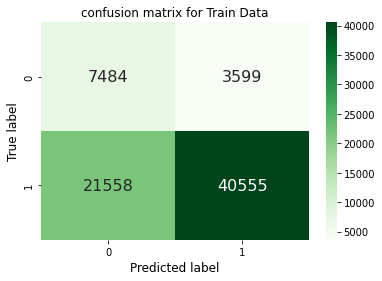

In [64]:
t_best = find_best_threshold(tr_thresholds,tr_fpr, tr_tpr) #train data
cm = metrics.confusion_matrix(y_train,predict_with_best_t(y_tr_probs,t_best))

print(cm)
sns.heatmap(cm,annot=True,fmt='d',cmap='Greens',annot_kws={'size':16})
plt.xlabel('Predicted label', size=12)
plt.ylabel('True label', size=12)
plt.title('confusion matrix for Train Data',size=12)


the maximum value of tpr*(1-fpr) 0.40986786993783686 for threshold 0.841
[[ 3390  2069]
 [10401 20192]]


Text(0.5, 1.0, 'confusion matrix for Train Data')

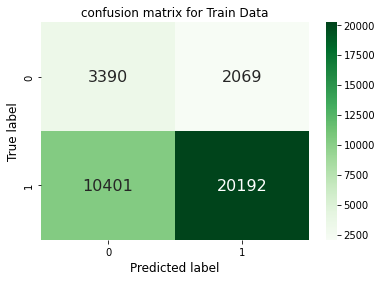

In [65]:
t_best = find_best_threshold(te_thresholds,te_fpr, te_tpr) #test data
cm = metrics.confusion_matrix(y_test,predict_with_best_t(y_te_probs,t_best))

print(cm)
sns.heatmap(cm,annot=True,fmt='d',cmap='Greens',annot_kws={'size':16})
plt.xlabel('Predicted label', size=12)
plt.ylabel('True label', size=12)
plt.title('confusion matrix for Train Data',size=12)


<h1>3. Summary</h1>

In [67]:
from prettytable import PrettyTable
from prettytable import ALL as ALL
table = PrettyTable(hrules=ALL)
table.field_names = ['s.no','vectorizer','model','hyper parameter','AUC']
table.add_row([1,'TFIDF','Gradient bossting classifier','max_depth=4 n_estimators=20','0.676'])
table.add_row([2,'TFIDF','Gradient bossting classifier','max_depth=4 n_estimators=20','0.685'])
print(table)

+------+------------+------------------------------+-----------------------------+-------+
| s.no | vectorizer |            model             |       hyper parameter       |  AUC  |
+------+------------+------------------------------+-----------------------------+-------+
|  1   |   TFIDF    | Gradient bossting classifier | max_depth=4 n_estimators=20 | 0.676 |
+------+------------+------------------------------+-----------------------------+-------+
|  2   |   TFIDF    | Gradient bossting classifier | max_depth=4 n_estimators=20 | 0.685 |
+------+------------+------------------------------+-----------------------------+-------+
